<a href="https://colab.research.google.com/github/naz-picones/MO-IT128-DMP-A3107-Lucero-Picones-Ramos/blob/main/MO_IT128_Homework_Project_Clustering_and_Segmentation_BSIT_A3107_Lucero%2CC_J%2C_Ramos%2C_M_G%2C_Picones%2CM_N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, glob
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Display
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [4]:
ZIP_PATH = None  # e.g., "MO-IT128-DMP-A3107-Lucero-Picones-Ramos-main.zip"

if ZIP_PATH is not None:
    from zipfile import ZipFile
    with ZipFile(ZIP_PATH, "r") as z:
        z.extractall("finmark_project")
    BASE_DIR = "finmark_project"
else:
    # If you uploaded CSVs directly, keep BASE_DIR as current folder.
    BASE_DIR = "."

print("BASE_DIR:", BASE_DIR)

BASE_DIR: .


In [5]:
def find_first(patterns, base_dir="."):
    for pat in patterns:
        hits = glob.glob(os.path.join(base_dir, "**", pat), recursive=True)
        if hits:
            # Prefer the shortest path (usually the most direct copy)
            hits = sorted(hits, key=lambda x: (len(x), x))
            return hits[0]
    return None

paths = {
    "transaction_aggregates": find_first(
        ["Transaction_Aggregates.csv", "*Transaction_Aggregates*.csv"],
        base_dir=BASE_DIR
    ),
    "customer_feedback_engineered": find_first(
        ["Customer_Feedback_Engineered.csv", "*Customer_Feedback_Engineered*.csv"],
        base_dir=BASE_DIR
    ),
    "transaction_engineered": find_first(
        ["Transaction_Engineered.csv", "*Transaction_Engineered*.csv"],
        base_dir=BASE_DIR
    ),
    "finmark_final": find_first(
        ["FinMark_Final.csv", "*FinMark_Final*.csv"],
        base_dir=BASE_DIR
    ),
}

paths

{'transaction_aggregates': './MO-IT128-DMP-A3107-Lucero-Picones-Ramos-main/Project Exploratory Data Analysis Report/Transaction_Aggregates.csv',
 'customer_feedback_engineered': './MO-IT128-DMP-A3107-Lucero-Picones-Ramos-main/Project Exploratory Data Analysis Report/Customer_Feedback_Engineered.csv',
 'transaction_engineered': './MO-IT128-DMP-A3107-Lucero-Picones-Ramos-main/Project Exploratory Data Analysis Report/Transaction_Engineered.csv',
 'finmark_final': './MO-IT128-DMP-A3107-Lucero-Picones-Ramos-main/Milestone 1/FinMark_Final.csv'}

In [6]:
def safe_read_csv(path):
    if path is None:
        return None
    return pd.read_csv(path)

df_tx_agg = safe_read_csv(paths["transaction_aggregates"])
df_fb = safe_read_csv(paths["customer_feedback_engineered"])
df_final = safe_read_csv(paths["finmark_final"])

print("Transaction_Aggregates:", None if df_tx_agg is None else df_tx_agg.shape)
print("Customer_Feedback_Engineered:", None if df_fb is None else df_fb.shape)
print("FinMark_Final:", None if df_final is None else df_final.shape)

Transaction_Aggregates: (993, 7)
Customer_Feedback_Engineered: (1000, 7)
FinMark_Final: (5000, 14)


In [7]:
if df_tx_agg is not None:
    display(df_tx_agg.head())
if df_fb is not None:
    display(df_fb.head())


,Customer_ID,Transaction_Count,Total_Amount,Avg_Amount,Std_Amount,Min_Amount,Max_Amount
0,1,6,16836.0,2806.0,2062.310646,156.0,4993.0
1,2,2,4907.0,2453.5,560.735677,2057.0,2850.0
2,3,1,1538.0,1538.0,0.000000,1538.0,1538.0
3,4,2,8295.0,4147.5,832.264681,3559.0,4736.0
4,5,5,14798.0,2959.6,1386.584040,1508.0,4878.0


,Customer_ID,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend,Satisfaction_Category,Comment_Length,Satisfaction_Recommendation_Gap
0,1,10.0,Very satisfied,9,High,14,1.0
1,2,3.0,Very satisfied,3,Low,14,0.0
2,3,10.0,Very satisfied,1,High,14,9.0
3,4,7.0,Needs improvement,4,Medium,17,3.0
4,5,8.0,Unsatisfactory,7,High,14,1.0


##Clustering table (customer-level)

In [8]:
# Build customer_profile from transaction aggregates + feedback engineered
if df_tx_agg is None and df_final is not None:
    # Fallback: create aggregates from FinMark_Final if needed
    tx = df_final.copy()
    if "Transaction_Amount" in tx.columns:
        tx["Transaction_Amount"] = pd.to_numeric(tx["Transaction_Amount"], errors="coerce")
    customer_profile = (
        tx.groupby("Customer_ID")["Transaction_Amount"]
          .agg(Transaction_Count="count",
               Total_Amount="sum",
               Avg_Amount="mean",
               Std_Amount="std",
               Min_Amount="min",
               Max_Amount="max")
          .reset_index()
    )
elif df_tx_agg is not None:
    customer_profile = df_tx_agg.copy()
else:
    raise ValueError("Could not find Transaction_Aggregates.csv or FinMark_Final.csv to build customer features.")

if df_fb is not None:
    customer_profile = customer_profile.merge(df_fb, on="Customer_ID", how="left")

print("Customer profile shape:", customer_profile.shape)
display(customer_profile.head())

Customer profile shape: (993, 13)


,Customer_ID,Transaction_Count,Total_Amount,Avg_Amount,Std_Amount,Min_Amount,Max_Amount,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend,Satisfaction_Category,Comment_Length,Satisfaction_Recommendation_Gap
0,1,6,16836.0,2806.0,2062.310646,156.0,4993.0,10.0,Very satisfied,9,High,14,1.0
1,2,2,4907.0,2453.5,560.735677,2057.0,2850.0,3.0,Very satisfied,3,Low,14,0.0
2,3,1,1538.0,1538.0,0.000000,1538.0,1538.0,10.0,Very satisfied,1,High,14,9.0
3,4,2,8295.0,4147.5,832.264681,3559.0,4736.0,7.0,Needs improvement,4,Medium,17,3.0
4,5,5,14798.0,2959.6,1386.584040,1508.0,4878.0,8.0,Unsatisfactory,7,High,14,1.0


##Feature selection & cleaning


In [9]:
# Columns to ALWAYS exclude from clustering
EXCLUDE_COLS = {
    "Customer_ID", "Transaction_ID", "Product_ID",
    "Transaction_Date", "Feedback_Comments", "Comment", "Comments"
}

# Detect numeric columns automatically
numeric_cols = customer_profile.select_dtypes(include=[np.number]).columns.tolist()

# Remove excluded columns if they happen to be numeric
numeric_cols = [c for c in numeric_cols if c not in EXCLUDE_COLS]

print("Numeric features detected:", numeric_cols)

# Create feature matrix
X = customer_profile[numeric_cols].copy()

# Fill missing values
X = X.fillna(X.median(numeric_only=True))

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X.shape)


Numeric features detected: ['Transaction_Count', 'Total_Amount', 'Avg_Amount', 'Std_Amount', 'Min_Amount', 'Max_Amount', 'Satisfaction_Score', 'Likelihood_to_Recommend', 'Comment_Length', 'Satisfaction_Recommendation_Gap']
X shape: (993, 10)


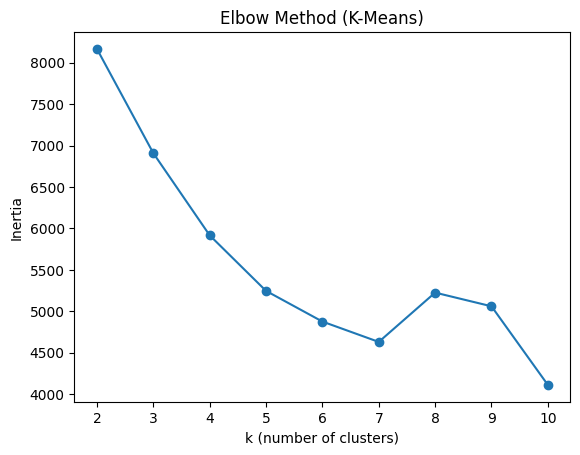

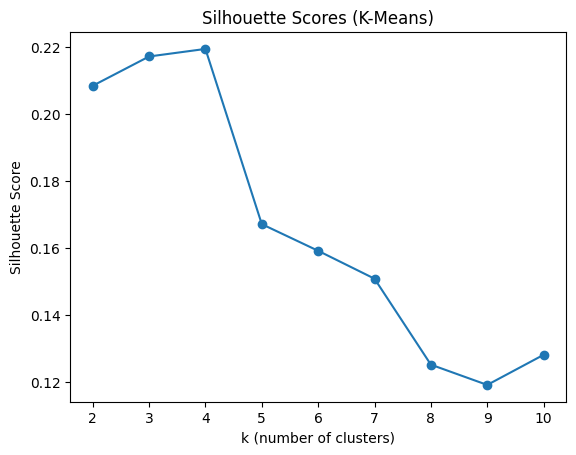

Best k by silhouette: 4


In [10]:
ks = range(2, 11)
inertia = []
silhouettes = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X_scaled)
    inertia.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Elbow
plt.figure()
plt.plot(list(ks), inertia, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Method (K-Means)")
plt.show()

# Silhouette
plt.figure()
plt.plot(list(ks), silhouettes, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores (K-Means)")
plt.show()

best_k = int(ks[int(np.argmax(silhouettes))])
print("Best k by silhouette:", best_k)


## Fit K-Means and assign cluster labels

In [11]:
K = best_k  # change if you prefer a different k (e.g., 4 or 5)
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
customer_profile["Cluster"] = kmeans.fit_predict(X_scaled)

customer_profile[["Customer_ID", "Cluster"]].head()


,Customer_ID,Cluster
0,1,0
1,2,2
2,3,2
3,4,1
4,5,0


##Cluster profiling (summary table)

In [12]:
cluster_summary = customer_profile.groupby("Cluster")[numeric_cols].mean().round(2)
cluster_counts = customer_profile["Cluster"].value_counts().sort_index()

display(cluster_summary)
print("\nCluster sizes:")
display(cluster_counts)

,Transaction_Count,Total_Amount,Avg_Amount,Std_Amount,Min_Amount,Max_Amount,Satisfaction_Score,Likelihood_to_Recommend,Comment_Length,Satisfaction_Recommendation_Gap
Cluster,,,,,,,,,,
0,6.09,15185.41,2499.70,1555.48,620.67,4450.50,5.48,5.50,13.57,3.16
1,3.55,12530.63,3577.75,853.90,2650.84,4422.66,5.87,5.31,13.62,3.44
2,3.52,6051.84,1710.47,941.30,783.09,2708.40,5.36,5.41,13.39,3.30
3,6.00,21716.67,3766.98,1092.52,2177.67,4808.67,56.00,9.67,12.67,46.33



Cluster sizes:


,count
Cluster,
0,577
1,167
2,246
3,3


##Clusters using PCA (2D)


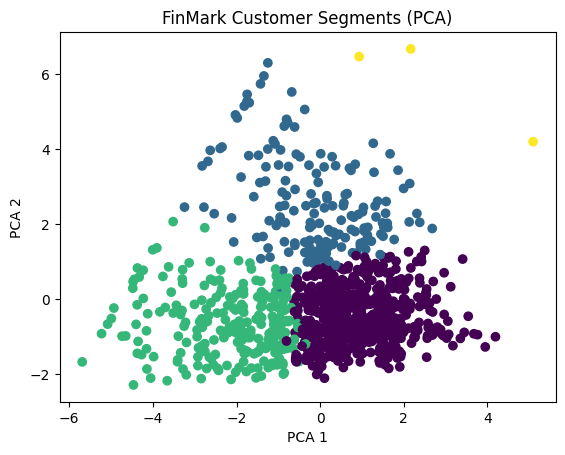

Explained variance by PCA components: [0.272 0.213]


In [13]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(coords[:, 0], coords[:, 1], c=customer_profile["Cluster"])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("FinMark Customer Segments (PCA)")
plt.show()

print("Explained variance by PCA components:", pca.explained_variance_ratio_.round(3))


In [14]:
# Auto-draft: rank clusters by spend and satisfaction (if columns exist)
summary = cluster_summary.copy()

spend_col = None
for c in ["Total_Amount", "Total_Spend", "Total_Transaction_Amount"]:
    if c in summary.columns:
        spend_col = c
        break

sat_col = "Satisfaction_Score" if "Satisfaction_Score" in summary.columns else None

if spend_col:
    spend_rank = summary[spend_col].rank(ascending=False, method="dense").astype(int)
else:
    spend_rank = pd.Series(index=summary.index, data=np.nan)

if sat_col:
    sat_rank = summary[sat_col].rank(ascending=False, method="dense").astype(int)
else:
    sat_rank = pd.Series(index=summary.index, data=np.nan)

lines = []
for cl in summary.index:
    line = f"Cluster {cl}: "
    if spend_col:
        line += f"{spend_col}={summary.loc[cl, spend_col]:.2f} (rank {spend_rank[cl]}), "
    if sat_col:
        line += f"{sat_col}={summary.loc[cl, sat_col]:.2f} (rank {sat_rank[cl]}), "
    line += f"size={cluster_counts[cl]}"
    lines.append(line)

print("DRAFT NOTES (edit these into your write-up):")
for l in lines:
    print("-", l)

DRAFT NOTES (edit these into your write-up):
- Cluster 0: Total_Amount=15185.41 (rank 2), Satisfaction_Score=5.48 (rank 3), size=577
- Cluster 1: Total_Amount=12530.63 (rank 3), Satisfaction_Score=5.87 (rank 2), size=167
- Cluster 2: Total_Amount=6051.84 (rank 4), Satisfaction_Score=5.36 (rank 4), size=246
- Cluster 3: Total_Amount=21716.67 (rank 1), Satisfaction_Score=56.00 (rank 1), size=3
